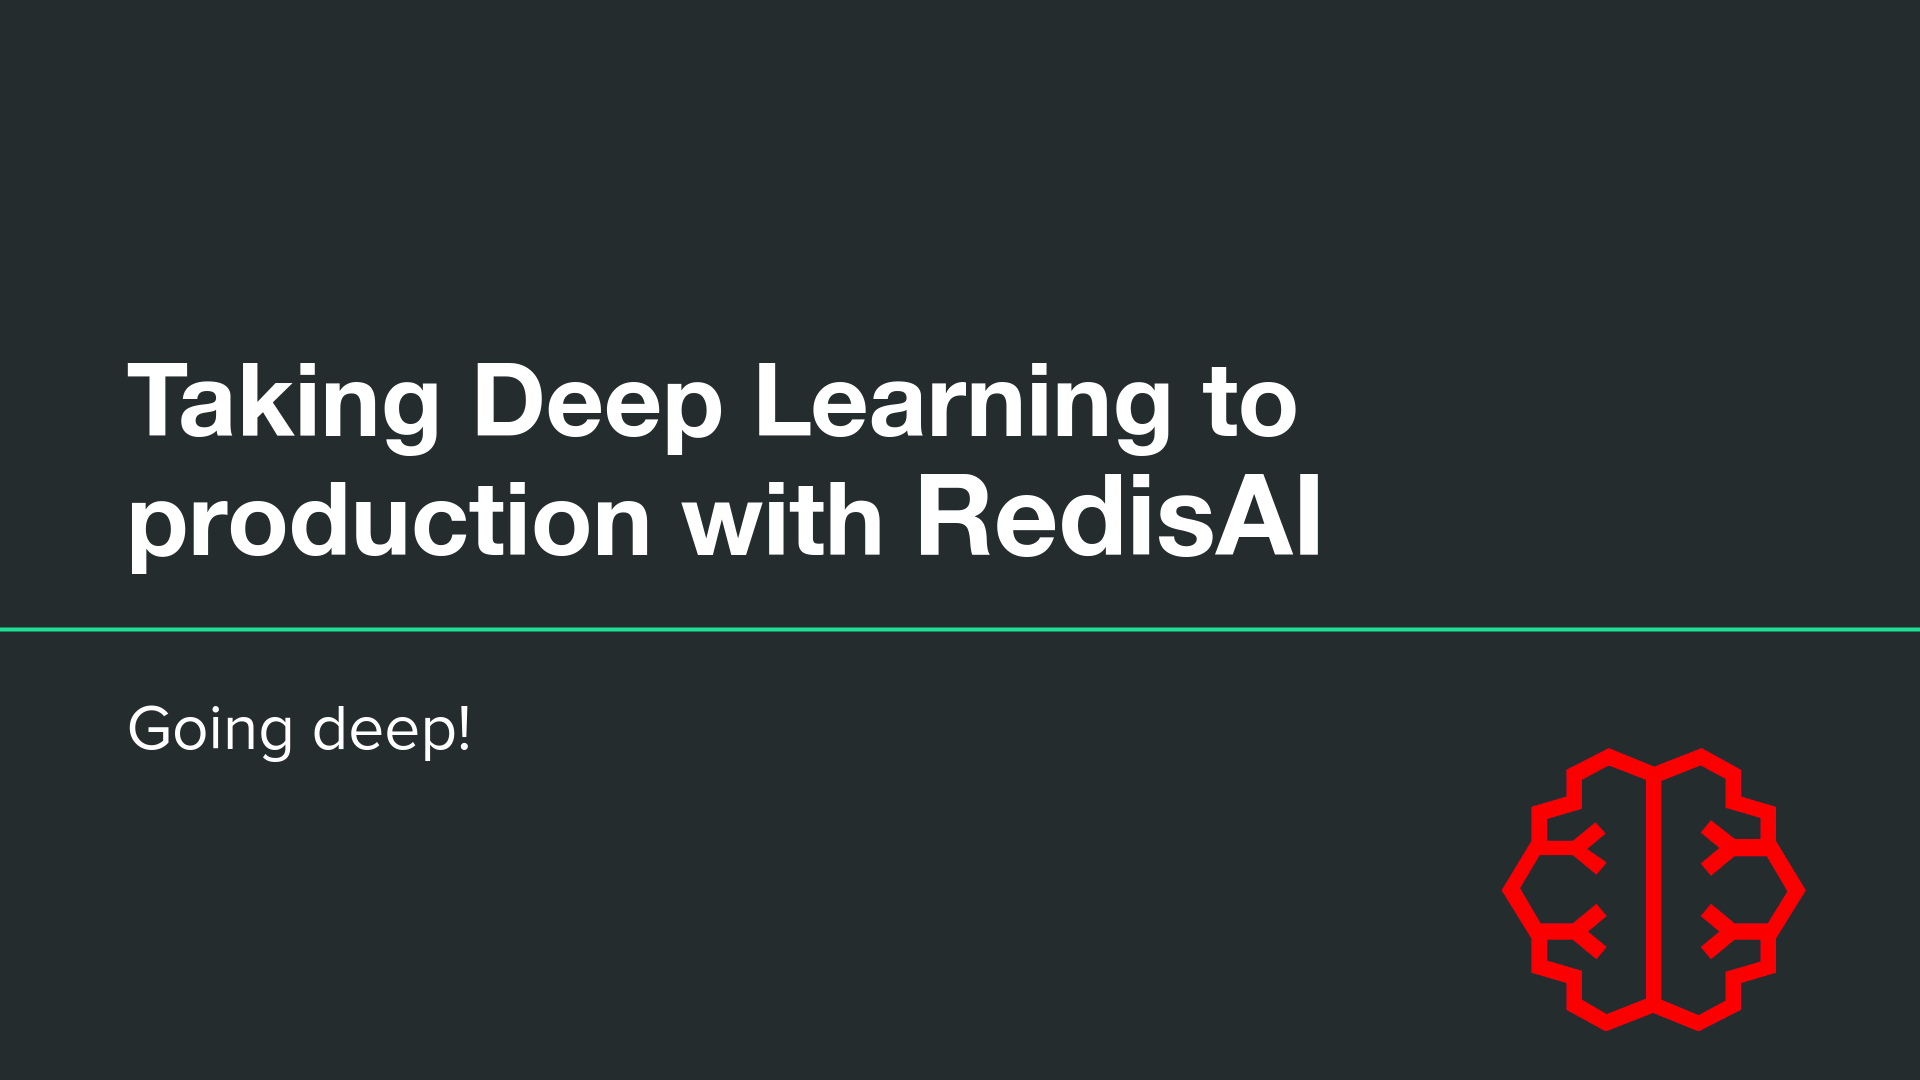

RedisAI is a Redis module for serving tensors and executing deep learning models. While RedisAI takes care of making a runtime for your model by supporting tensor datatypes and manages downstream runtimes built on top of Tensorflow, PyTorch and ONNXRuntime, Redis itself helps you handle the scale, for which Redis is known for.
Detailed blog: https://medium.com/tensorwerk/redisai-thors-stormbreaker-for-deep-learning-deployment-a3fe7569c559

But before we jumping in, let's take a step back and look into the current Deep Learning / Machine Learning world

# Deep Learning / Machine Learning - A precursor
- Matrices / Tensors
- Fundamental Operations
- Regression, Classification, Neural Networks & Deep Networks
- **Scikit Learn** example
- **Tensorflow** example
- **PyTorch** example

In [227]:
import numpy as np

In [228]:
np.random.random((5, 2))

array([[0.12780385, 0.05590735],
       [0.3403706 , 0.71442625],
       [0.75752239, 0.09811118],
       [0.19828625, 0.66425689],
       [0.34893955, 0.15602292]])

In [229]:
a = np.random.random((5, 7))
b = np.random.random((7, 2))
c = a @ b
print(f'On matrix multiplication: {c.shape}')

a = np.random.random((5, 3))
b = np.random.random((5, 3))
c = a + b
print(f'On addition: {c.shape}')

# Other math operations, activation functions etc

On matrix multiplication: (5, 2)
On addition: (5, 3)


### Linear Regression with Scikit Learn
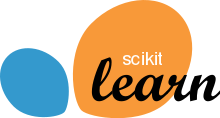

In [243]:
import sklearn
from sklearn.linear_model import LinearRegression

In [244]:
from sklearn.datasets import load_boston
boston = load_boston()
x, y = boston.data, boston.target
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [245]:
(x.shape, y.shape)

((506, 13), (506,))

In [246]:
testindex = 25
testarray = x[testindex]
testtarget = y[testindex]
for i in range(len(boston.feature_names)):
    print(f'{boston.feature_names[i]:<10}: {testarray[i]}')

CRIM      : 0.84054
ZN        : 0.0
INDUS     : 8.14
CHAS      : 0.0
NOX       : 0.538
RM        : 5.599
AGE       : 85.7
DIS       : 4.4546
RAD       : 4.0
TAX       : 307.0
PTRATIO   : 21.0
B         : 303.42
LSTAT     : 16.51


In [247]:
testtarget

13.9

In [248]:
model = LinearRegression()
model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [249]:
model.predict(testarray.reshape(1, -1))

array([13.38668561])

In [250]:
# needed later
sklearn_model = model

### Object Detection with Tensorflow
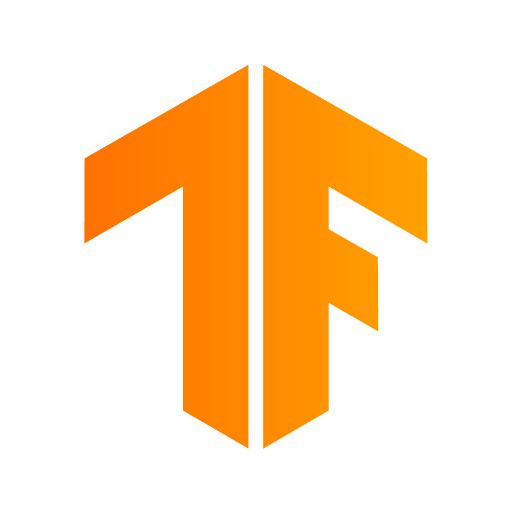

##### Load graph and required variables

In [347]:
import tensorflow as tf

In [348]:
# download the model from https://app.box.com/s/ottxnjxc1ev9wlqiw0gmsb87r9xzjkyd
frozen_graph = "../assets/yolo.pb"
with tf.gfile.GFile(frozen_graph, "rb") as f:
    restored_graph_def = tf.GraphDef()
    restored_graph_def.ParseFromString(f.read())
with tf.Graph().as_default() as graph:
    tf.import_graph_def(
        restored_graph_def,
        input_map=None,
        return_elements=None,
        name="")

In [349]:
inputs = graph.get_tensor_by_name('input_1:0')
image_shape = graph.get_tensor_by_name('input_image_shape:0')
boxes = graph.get_tensor_by_name('concat_11:0')
classes = graph.get_tensor_by_name('concat_13:0')

##### Load image

In [350]:
from PIL import Image, ImageDraw
image = '../assets/nightking.jpg'
img_jpg = Image.open(image)

##### preprocess

In [351]:
np_img = np.array(img_jpg)
img = np_img.astype(np.float32)
img = np.expand_dims(img, axis=0)
img /= 255.0

In [352]:
img.shape

(1, 416, 416, 3)

##### Run model

In [353]:
with tf.Session(graph=graph) as sess:
    sess.run([tf.global_variables_initializer()])
    ret_b, ret_c = sess.run([boxes, classes], feed_dict={inputs: img, image_shape: np.array((416, 416))})

In [354]:
shape = np_img.shape

##### Post process

In [355]:
new_shape = 416
def post_process(classes, boxes, shapes=(416, 416)):
    pad_x = max(shapes[0] - shapes[1], 0) * (new_shape / max(shapes))
    pad_y = max(shapes[1] - shapes[0], 0) * (new_shape / max(shapes))
    unpad_h = new_shape - pad_y
    unpad_w = new_shape - pad_x 
    for ind, class_val in enumerate(classes):
        top, left, bottom, right = boxes[ind]
        top = ((top.astype('int32') - pad_y // 2) / unpad_h) * shapes[0]
        left = ((left.astype('int32') - pad_x // 2) / unpad_w) * shapes[1]
        bottom = ((bottom.astype('int32') - pad_y // 2) / unpad_h) * shapes[0]
        right = ((right.astype('int32') - pad_x // 2) / unpad_w) * shapes[1]
        yield left, top, right, bottom

In [358]:
ret_b.dtype

dtype('float32')

##### Process output

In [140]:
draw = ImageDraw.Draw(img_jpg)

In [141]:
for left, top, right, bottom in post_process(ret_c, ret_b, shape):
    draw.rectangle(((left, top), (right, bottom)), outline='green')

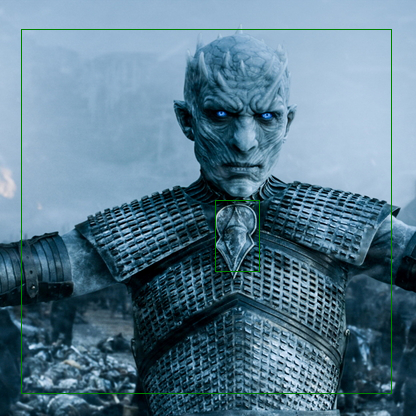

In [142]:
from IPython.display import display
display(img_jpg)

### Chatbot with PyTorch
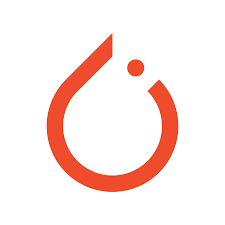

##### Importing torch

In [8]:
import torch

##### Utilities, helper constants etc.

In [9]:
import json
import re

voc_file = '../assets/voc.json'
with open(voc_file)as f:
    voc_content = json.load(f)
    w2i = voc_content['word2index']
    i2w = voc_content['index2word']

PAD_token = 0
SOS_token = 1
EOS_token = 2
max_len = 30

def normalize_string(s):
    s = s.lower()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def str2indices(sentence):
    return [[el for el in [w2i.get(word) for word in sentence.split()] if el is not None] + [EOS_token]]

def indices2str(indices):
    return ' '.join([i2w[str(ind)] for ind in indices])

##### Encoder & Decoder using PyTorch JIT

In [10]:
encoder = torch.jit.load('../assets/encoder.pt')
decoder = torch.jit.load('../assets/decoder.pt')

##### Processing input

In [11]:
import numpy as np
d_input = torch.tensor(SOS_token, dtype=torch.int64).reshape(1, 1)
mysentence = "I don't like this people"


indices = str2indices(normalize_string(mysentence))
array = torch.from_numpy(np.array(indices, dtype=np.long).transpose())
length = torch.from_numpy(np.array([len(array)], dtype=np.long))

##### Running encoder & decoder

In [12]:
e_out, hidden = encoder(array, length)

In [13]:
decoder_out = []
for i in range(max_len):
    out, hidden = decoder(d_input, hidden, e_out)
    spanned_out = out.reshape(1, -1)
    ind = spanned_out.argmax(1).item()
    if ind == EOS_token:
        break
    d_input = torch.tensor(ind, dtype=torch.int64).reshape(1, 1)
    if ind == PAD_token:
        continue
    decoder_out.append(ind)

##### Processing output

In [14]:
print(indices2str(decoder_out))

you don t have to .


In [226]:
# TODO - Paste Advantages slide
raise NotImplemented

TypeError: exceptions must derive from BaseException

# Getting Started with RedisAI

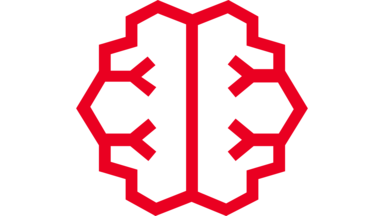

We'll start with installing RedisAI. Setting it up in a bare machine is few lines of commands and even for scaling it up for millions request per second, couple of config changes should be good enough.

## A quick introduction about the features of RedisAI??

### Setting up a new machine
```bash
sudo apt update 
sudo apt install -y build-essential tcl libjemalloc-dev git cmake unzip

sudo ufw allow 6379
sudo ufw allow 26379
```

### Installing Redis
```bash
curl -O http://download.redis.io/redis-stable.tar.gz
tar xzvf redis-stable.tar.gz
cd redis-stable
make
sudo make install
cd ~
rm redis-stable.tar.gz
```

### Building RedisAI module
```bash
git clone https://github.com/RedisAI/RedisAI.git
cd RedisAI
bash get_deps.sh cpu
mkdir build
cd build
cmake -DDEPS_PATH=../deps/install ..
make
cd ..
```


## However ...

```bash
docker run -p 6379:6379 -it --rm redisai/redisai
```

# Client Libraries

#### redis-cli
```bash
# Setting a tensor using redis-cli
AI.TENSORSET foo FLOAT 2 2 VALUES 1 2 3 4
```

#### Python Redis client
```python
# Setting a tensor using python Redis client
import redis
r = redis.Redis(host='localhost', port=6379)
r.execute_command('AI.TENSORSET', 'foo', 'FLOAT', 2, 2, 'VALUES', 1, 2, 3, 4)
```

#### Python RedisAI client
```python
# Setting a tensor using Python RedisAI client
import redisai as rai
con = rai.Client(host='localhost', port=6379)
foo = rai.Tensor(rai.DType.float, [2, 2], [1, 2, 3, 4])
con.tensorset('foo', foo)
```

#### NodeJS Redis client
```node
// Setting a tensor using NodeJS Redis client
var Redis = require('ioredis')
let redis = new Redis({ parser: 'javascript' });
redis.call('AI.TENSORSET','foo','FLOAT',2,2,'VALUES',1,2,3,4)
```

#### Go Redis client
```go
// Setting a tensor using GoLang Redis client
package main
import "github.com/go-redis/redis"
func main() {
    client := redis.NewClient(&redis.Options{
            Addr:     "localhost:6379",
            Password: "",
        })      
    client.Do("AI.TENSORSET","foo","FLOAT",2,2,"VALUES",1,2,3,4)
}
```

In [1]:
import redisai as rai
con = rai.Client(host='localhost', port=6379)
foo = rai.Tensor(rai.DType.float, [2, 2], [1, 2, 3, 4])
con.tensorset('foo', foo)

b'OK'

### A quick glimpse into redisai python client

In [2]:
import redisai

##### ValueTensor and BlobTensor

In [3]:
con = redisai.Client(host='localhost', port=6379)
foo = rai.Tensor(rai.DType.float, [2, 2], [1, 2, 3, 4])
con.tensorset('foo', foo)

b'OK'

In [4]:
import numpy as np
random_array = np.random.random((3, 4))
foo = redisai.BlobTensor.from_numpy(random_array)
con.tensorset('foo', foo)

b'OK'

##### Modelset & Scriptset
```python
con.modelset('whaaaaaaaaaat?')
con.scriptset('whaaaaaaaaat again??')
```

### ml2rt

In [5]:
import ml2rt

In [16]:
# prototype=x[0].reshape(1, -1).astype(np.float32) what is this?
# shape=(1, 13), dtype=np.float32, what is this?
# ml2rt.utils.guess_onnx_tensortype(x[0].reshape(1, -1).astype(np.float32))
# initial_types=[ml2rt.utils.guess_onnx_tensortype(x[0].reshape(1, -1).astype(np.float32))]


ml2rt.save_sklearn(sklearn_model, '../assets/boston.onnx')

NameError: name 'sklearn_model' is not defined

In [17]:
dir(ml2rt)

['__author__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__email__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'exporter',
 'importer',
 'load_model',
 'load_script',
 'save_onnx',
 'save_sklearn',
 'save_sparkml',
 'save_tensorflow',
 'save_torch',
 'utils']

In [269]:
sklearn_model = ml2rt.load_model('../assets/boston.onnx')

In [271]:
con.modelset('sklearn', redisai.Backend.onnx, redisai.Device.cpu, sklearn_model)

b'OK'

In [273]:
con.modelrun('Not now!!')

TypeError: modelrun() missing 2 required positional arguments: 'input' and 'output'

In [272]:
script_string = '''
def add_two(a, b):
    return a + b

'''
con.scriptset('script', redisai.Device.cpu, script_string)

b'OK'

In [301]:
tensor = redisai.BlobTensor.from_numpy(np.array([1, 2]))

con.tensorset('a', tensor)
con.tensorset('b', tensor)
con.scriptrun('script', 'add_two', input=['a', 'b'], output='c')

b'OK'

In [308]:
ret = con.tensorget('c')
ret

<Tensor(shape=[2] type=INT64) at 0x7fa191000438>

In [307]:
ret = con.tensorget('c', as_type=redisai.BlobTensor)
ret

<BlobTensor(shape=[2] type=INT64) at 0x7fa1910002b0>

## Enough of that!! Let's run through our examples
--------------------------------------------------------------------------
## Logistic regression with scikit-learn

In [310]:
sklearn_model = ml2rt.load_model('../assets/boston.onnx')
con.modelset('sklearn', redisai.Backend.onnx, redisai.Device.cpu, sklearn_model)

In [312]:
tensor = redisai.BlobTensor.from_numpy(x[testindex].reshape(1, -1).astype(np.float32))
con.tensorset('input', tensor)
con.modelrun('sklearn', input='input', output='out')

b'OK'

In [313]:
con.tensorget('out').value

[13.386686325073242]

## Object Detection with Tensorflow

In [365]:
yolomodel = ml2rt.load_model('../assets/yolo.pb')
# input=['input_1', 'input_image_shape'], output=['concat_11', 'concat_13']
con.modelset('yolo', redisai.Backend.tf, redisai.Device.cpu, yolomodel)

ValueError: Require keyword arguments input and output for TF models

In [371]:
image = '../assets/nightking.jpg'
img_jpg = Image.open(image)

In [372]:
script = '''

def normalize(img):
    img /= 255
    return img

def pre_process(img):
    img = img.float()
    img = img.unsqueeze(0)
    normalize(img)
    return img
'''
# A common error point
con.scriptset('script', redisai.Device.cpu, script)

b'OK'

In [373]:
tensor = redisai.BlobTensor.from_numpy(np.array(img_jpg))
img_new_size = redisai.Tensor(redisai.DType.float, (2,), (416, 416))
con.tensorset('image', tensor)
con.tensorset('input_size', img_new_size)

b'OK'

In [374]:
con.scriptrun('script', 'pre_process', 'image', 'processed_image')

b'OK'

In [375]:
con.tensorget('processed_image', as_type=redisai.BlobTensor)

<BlobTensor(shape=[1, 416, 416, 3] type=FLOAT) at 0x7fa17f500198>

In [376]:
con.modelrun('yolo', input=['processed_image', 'input_size'], output=['boxes', 'classes'])

b'OK'

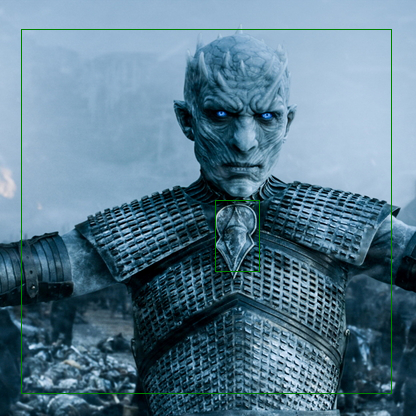

In [380]:
boxes = con.tensorget('boxes', as_type=redisai.BlobTensor).to_numpy()
classes = con.tensorget('classes', as_type=redisai.BlobTensor).to_numpy()
coordinates = post_process(classes, boxes)
for left, top, right, bottom in coordinates:
    draw.rectangle(((left, top), (right, bottom)), outline='green')

draw = ImageDraw.Draw(img_jpg)
display(img_jpg)

## Chatbot with PyTorch

In [17]:
encoder = ml2rt.load_model('../assets/encoder.pt')
decoder = ml2rt.load_model('../assets/decoder.pt')

In [18]:
mysentence = "I don't like this people"

indices = str2indices(normalize_string(mysentence))
np_array = np.array(indices, dtype=np.long).transpose()
array = redisai.BlobTensor.from_numpy(np_array)
length = redisai.BlobTensor.from_numpy(np.array([len(np_array)], dtype=np.long))
d_input = redisai.Tensor(value=SOS_token, dtype=redisai.DType.int64, shape=(1, 1))

In [19]:
con.modelset('encoder', redisai.Backend.torch, redisai.Device.cpu, encoder)
con.modelset('decoder', redisai.Backend.torch, redisai.Device.cpu, decoder)
con.tensorset('sentence', array)
con.tensorset('length', length)
con.tensorset('d_input', d_input)

b'OK'

In [20]:
con.modelrun('encoder', input=['sentence', 'length'], output=['e_out', 'hidden'])

b'OK'

In [27]:
decoder_out = []
for i in range(max_len):
    # Don't have to carry around `hidden` and `e_out`
    con.modelrun('decoder', input=['d_input', 'hidden', 'e_out'], output=['out', 'hidden'])
    out = con.tensorget('out', as_type=redisai.BlobTensor).to_numpy()
    spanned_out = out.reshape(1, -1)
    ind = spanned_out.argmax().item()
    if ind == EOS_token:
        break
    d_input = redisai.Tensor(value=ind, dtype=redisai.DType.int64, shape=(1, 1))
    con.tensorset('d_input', d_input)
    if ind == PAD_token:
        continue
    decoder_out.append(ind)

In [26]:
indices2str(decoder_out)

'you don t have to .'